<a href="https://colab.research.google.com/github/pscicluna/IntroToBayes/blob/main/IntroToBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Bayes' Theorem
## Peter Scicluna, Teaching presentation

### What this presentation will cover
In this presentation, we will briefly cover:

1. How the simple answer can lead to the wrong conclusion
2. How Bayes' theorem can help you out

And then summarise where we have gotten to.
We will use a classical (even cliche) example, but it's a classic because it works!

If this were a full-length lesson, it would also extend to:

3. Bayesian updating
4. Choosing priors and evaluating their impact

At the end of the notebook there are a few example problems for you to consider in your own time.


### Prior knowledge
Based on the outlines for the *Linear Modelling* and *Fundamentals of Data Science* course,  I'm assuming the following prior knowledge:

* Basic probability theory
* Frequentist statistics
* basic Python
* linear regression

If anything is unclear, please let me know! I will attempt to adjust on the fly, but if that's impossible I am happy to discuss further outside of this session.

If you would like to follow along, you can find this notebook at: https://github.com/pscicluna/IntroToBayes/IntroToBayes.ipynb


### Disease incidence

Let's say I take one of these tests:

![COVID-19 Lateral Flow Test with weak test line visible](https://npr.brightspotcdn.com/dims4/default/208129e/2147483647/strip/true/crop/640x360+0+0/resize/880x495!/quality/90/?url=http%3A%2F%2Fnpr-brightspot.s3.amazonaws.com%2F8e%2F4e%2F67c45fca4b78a4934c418ae88198%2Fwoster-covid-test.jpg)



If I test positive, what is the probability that I am really infected?

Assume the false-positive probability $P\left(+|\tilde{I}\right)$ = 0.05 and the false-negative probability is 0.

To answer the poll, scan this QR Code:

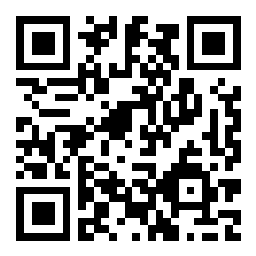

Or follow this link:
https://app.sli.do/event/8X9cWAzadzyzJUv4VB6gM2

Yes, this is something of a trick question! Unfortunately, we need more information to come up with a concrete answer to this question. Why is that?

To get to the real answer, we need to think about what happens if we test a population of people, in which some fraction are really infected.

If we test 100 people, with a real incidence (i.e. what fraction of the population is really infected) of 1%, how many positive results should we get?

Well, why don't we do the maths?
There are 4 possible outcomes:

| Status($→$)/result(↓)  |  Infected ($I$) | Not infected ($\tilde{I}$) |
|---|---|---|
| Positive ($+$)  |  true positive ($+|I$) | false positive ($+|\tilde{I}$) |
| Negative ($-$ or $\tilde{+}$)  |  false negative ($\tilde{+}|I$) | true negative ($\tilde{+}|\tilde{I}$) |

First we can calculate the expected number of *true* positives, which assuming the test has a false-negative probability $P\left(\tilde{+}|I\right)= 0$ as above, is incidence $\times$ sample size. This should be 1, since we have a sample of 100 and 1% incidence:



In [2]:
sample=100
incidence = 0.01
n_true_pos = sample * incidence
print(n_true_pos)

1.0


Next, we can consider the expected number of *false* positives, which is false-positive probability $\times$ sample size (but a positive cannot be both true and false, so true positives must be excluded).

In [3]:
false_pos_probability = 0.05
n_false_pos = (sample - n_true_pos) * false_pos_probability
print(n_false_pos)

4.95


Now we can easily get the expected **total** number of positives by adding these up:

In [4]:
total_pos = n_true_pos + n_false_pos
print(total_pos)

5.95


As you can see, in this scenario we should actually end up with six positive results, of which only one is real! What does this mean for our probability to be infected if we test positive? If we follow the definition of probability based on frequency, then we arrive at the probability of being infected being the ratio of the number of true positives to the total number of positive results:

In [5]:
prob_infected = n_true_pos / total_pos
print(prob_infected)

0.1680672268907563


So, why isn't the answer 0.95?

That's right, the number of false positives depends only on the size of the sample and the false-positive probability<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1), but the number of true positives depends on the incidence!

So how would our answer be different if the incidence was 50%?

In [6]:
incidence = 0.5
n_true_pos = sample * incidence
n_false_pos = (sample - n_true_pos) * false_pos_probability
total_pos = n_true_pos + n_false_pos
prob_infected = n_true_pos / total_pos
print(prob_infected)

0.9523809523809523


You can see this is much larger, and now roughly equal to the naive assumption of 0.95! If you're following along offline, try changing the incidence some more and see what happens!

To see how it depends on the incidence, we can plot many values at once:

(0.0, 1.0)

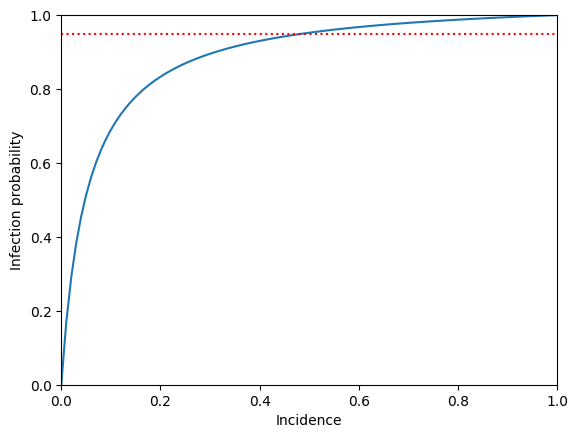

In [7]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

incidences = np.arange(101)/100

n_true_pos = sample*incidences
n_false_pos = (sample - n_true_pos) * false_pos_probability
total_pos = n_true_pos + n_false_pos

prob_infected = n_true_pos / total_pos
plt.plot(incidences, prob_infected, '-')
plt.axhline(0.95, linestyle=':', color='red')
plt.xlabel('Incidence')
plt.ylabel('Infection probability')
plt.xlim([0, 1])
plt.ylim([0, 1])

What is going on here? Well, it looks like the the probability increases with the incidence, and is only equal to 1 minus the false-positive probability when the incidence is 0.5. Why? To answer that, we will have to do a little bit of maths:

The false-positive probability can be thought of as the probability of testing positive if you are not infected, $P\left(+|\tilde{I}\right)$, and so the probability of testing positive if you are infected is $P\left(+|I\right) = 1 - P\left(+|\tilde{I}\right)$. However, what we're trying to estimate is $P\left(I|+\right)$ instead!

### Rev. Thomas Bayes

18th century Presbytarian minister, worked extensively on *conditional probability*.

What did Bayes discover? Consider the intersection of two samples:

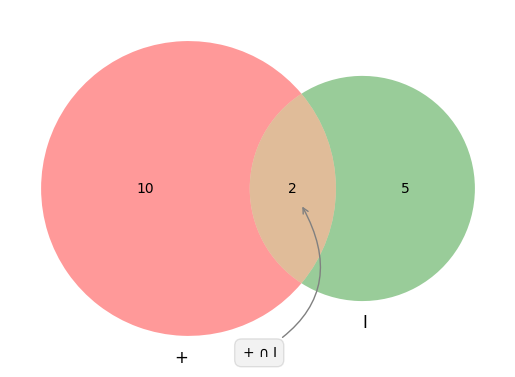

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

# Use the venn2 function
v = venn2(subsets = (10, 5, 2), set_labels = ('+', 'I'))
plt.annotate('+ $\cap$ I', xy=v.get_label_by_id('100').get_position() - np.array([-0.5, 0.05]), xytext=(-30,-110),
             ha='center', textcoords='offset points', bbox=dict(boxstyle='round,pad=0.5', fc='gray', alpha=0.1),
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5',color='gray'))
plt.show()

If we want to know the *joint probability* of A and B then we want the intersection of the two sets $P\left(+, I\right) = P\left(x \in + \cap I\right)$


If we translate this into probability notation we end up with:
\begin{align}
P\left(+, I\right) &= P\left(x \in + \cap I\right) &&= P\left(x \in I \cap +\right)\\
 &=P\left(x\in +|x\in I\right)P\left(x\in I\right) &&= P\left(x\in I|x\in +\right)P\left(x\in +\right)\\
 &= P\left(+|I\right)P\left(I\right) &&= P\left(I|+\right)P\left(+\right)
\end{align}
which is a suprisingly simple but important result. Also known as "the chain rule of probability", this allows us to easily transform between different conditional probabilities.

Obviously this doesn't care what sort of probabilities we're talking about, so we can easily generalise this to provide the canonical version of Bayes' now famous theorem:$$P(A|B)P(B) = P(B|A)P(A)$$

What does this mean for us? Well, we can now take this  and solve for $P\left(I|+\right)$!

If we do that, what do we end up with?

$$P\left(I|+\right) = \frac{P\left(+|I\right)P\left(I\right)}{P\left(+\right)}$$

Okay, but some of these terms need to be expanded to be useful.
For example, the incidence can be thought of as the probability of a randomly chosen individual being positive $P\left(I\right)$, but we also need the probability of any positive result $P(+)$. Clearly, this is equal to the sum of the true and the false positives, so this is
$$P(+) = P\left(+|I\right)P\left(I\right) + P\left(+|\tilde{I}\right)P\left(\tilde{I}\right)$$ which are all quantities we know!

So we can turn all of this into code and see what the results are:

In [9]:
p_i = incidences
p_pos_given_i = 1 - false_pos_probability
p_pos = p_pos_given_i * p_i + false_pos_probability * (1 - incidences)
p_i_given_pos = p_pos_given_i * p_i / p_pos

And we can overplot this on our previous results to show how they agree:

(0.0, 1.0)

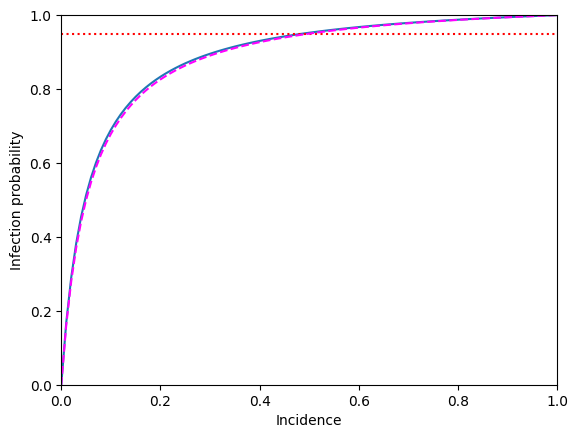

In [10]:
%matplotlib inline
plt.plot(incidences, prob_infected, '-')
plt.axhline(0.95,linestyle=':', color='red')
plt.plot(incidences, p_i_given_pos, '--', color='magenta')
plt.xlabel('Incidence')
plt.ylabel('Infection probability')
plt.xlim([0, 1])
plt.ylim([0, 1])

As you can see, this formula perfectly follows the empirical relationship we computed above! So essentially, just by *thinking hard* about the problem, we can come to an effective solution.

**Discussion point:** the plot shows I can essentially choose my result by changing my assumption about the incidence. How might someone get around this?

### Why Bayes?
**Why does this matter**, you might ask?

Well, following this example, it matters because you don't want to treat someone unnecessarily, because any treatment can cause side effects. So, if you test someone for a rare disease, and the incidence is below the false-positive probability, you might want to confirm it some other way before you begin treating them.

More generally, when you're interpreting your data, you want to give less credence to cases that seem less likely; essentially, Bayes' theorem gives you a mathematical tool for encoding the truism **_"extraordinary claims require extraordinary evidence"_** and weighting your results accordingly.

In the *Linear Modelling* course and the description of linear regression, you might have encountered regression as the problem of finding the *maximum likelihood* parameters for a dataset given a model.
Therefore, linear regression solves the question of *how probable is my dataset under the assumption of some model/parameters* i.e.
$$P\left(D|M\right).$$

But when you're trying to interpret your dataset to understand what the best parameters are, you really want to know the probability of your model given some data or
$$P\left(M|D\right),$$
which is commonly referred to as the *posterior probability* or just **posterior**.

So, using Bayes' theorem, can we go from one to the other? What is missing:

$$P\left(M|D\right) = \frac{P\left(D|M\right)}{}.$$

You will see that we have introduced a few new factors here that we need to define. You're already familiar with the likelihood $P\left(D|M\right)$ and we introduced the posterior $P\left(M|D\right)$ already. The two other terms in the most interesting: $P(M)$ is referred to as the *prior probability*, and it encodes any existing information we have about the distribution of models or parameters, while $P(D)$, called the *evidence*, is key to more advanced analysis such as *model selection*, but is otherwise often treated simply as a normalisation factor.

### Why Bayes?

So why does this matter for understanding a model, or *doing science*?

The prior, although a point of contention for frequentists, is key. The criticism is that, by changing your prior you can essentially produce any result you want. However, a more productive way of looking at it is that **your assumption is now completely explicit and its impact can be easily tested**, while similar assumptionts may be implicitly baked in and hard to test in a frequentist analysis.

Another advantage of this approach is that now every part of our inference is explicitly a distribution. This means we can propagate uncertainty easily, which is important - a value without a meaningful uncertainty doesn't let us test a theory, and doesn't tell us how confident we should be if we're making predictions!

### Bayesian Updating

What happens if I take two tests, and both are positive? What is the probability that I'm really infected then? This section of the class would expand on the topic of repeated measurements. We will consider both repeating measurements of the test above, detour through the Monty Hall problem, and then come back to testing above and explore it in practice.

### Choosing priors
The final section of the class would consider the tricky question of choosing priors, starting from the example of Eddington bias. It would then introduce the concepts of informative vs uninformative priors, Jeffrey's priors, and finally *conjugate* priors. Then it would explore the idea of prior sensitivity tests in linear regression and how important this is to ensuring an analysis is robust.

### Sampling distributions

One of the great things that Bayes' theorem has enabled is the widespread application of algorithms such as Markov Chain Monte Carlo to sample posterior distributions. By providing an easy way to combine distributions we can easily produce samples even from dsitributions that we can't directly evaluate. This means even complex physical models can be computed and we can figure out which models the data support! You will no-doubt encounter this in a later lecture, but efficient sampling is a major field of research that is partcularly relevant to my own research.

### Problem set:

The rest of this notebook is a set of problems for you to solve yourselves in class. They cover a few different applications of what we covered here, and some extensions to make you think a bit more as well. These problems will form part of your assessment.


#### Problem 1: Changing the false-positive probability

Revisit the infection positivity example above, and explore how changing the false-positive probability changes the outcome. Make a version of the figures above that shows how the outcome changes as your assumptions about the test change.

In [11]:
# Compute the answer to the problem here!

# Don't forget to make a new plot as well!

# Use multiple code & Markdown cells if you need to.

#### Problem 2: Non-zero false-negative probability

Above, we assumed that the false-negative probability is 0. Derive the equation for $P\left(I|+\right)$ if this is no longer true. Then compute the solution with a false-negative probability of 0.05 using python below.

#### Problem 3: Bayesian updating

In the section above, we considered repeating identical tests. However, in practice, the second test will be significantly different than the first - more expensive, and often with lower false-positive and false-negative probabilities. Make some reasonable assumptions about two different tests for the same disease, and clearly justify them. Then calculate the posterior probability that the person is really infected as a function of the incidence, after they have taken both tests. For bonus points, illustrate how this changes as the properties of the tests change. Discuss your results and their implications.

#### Problem 4: Prior sensitivity testing

We finished by introducing prior sensitivity testing. In the cell below, consider Bayesian linear regression and explore how changing the prior affects the outcome of fitting a straight line to a simple dataset.

### Footnotes

<a name="cite_note-1"></a>1. [^](#cite_ref-1) This is an oversimplication, as you can see from the code - it depends somewhat on the incidence, because only uninfected people can produce false positives. However, in the limit of low incidence, this is approximately true.